In [18]:
"""Delete ths cell when done!"""
%load_ext autoreload
%autoreload complete

In [1]:
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s = {
    'problem'           : "regression",
    'approach'          : "few-shot learning",
    'method'            : "non-parametric",
    'algorithm'         : "siamese network",
    'goal'              : "learn a distribution using few samples from it",
    'input'             : "samples from a distribution",
    'input type'        : "vectors",
    'input meaning'     : "spectrum", 
    'output'            : "samples from a distribution",
    'output type'       : "one number",
    'output meaning'    : "temperature or pressure, depending on distribution",
    'number of ways'    : 2,
    'number of shots'   : 1,
    'number of folds'   : 8,
    'support-query ratio': 0.8,
    'task size'         : 5,
    'learning rate'     : 1e-4,
    'input dimension'   : 10000,
    'output dimension'  : 1,
    'feature dimension' : 300,
    'epoch'             : 1000,
    'epoch development' : 4,
    'data'              : 'temperature_230509_discrete',
    'data P'            : 'pressure_230516_discrete',
    'data T'            : 'temperature_230509_discrete',
    'cross validation round': 16,
    'cross validation round-development' : 3,
    'batch size'        : 32,
    'best model folder' : 'SiameseAux_multi_P->T/'
}

In [2]:
import data_accessor as acc
data_names_list = [
    'temperature_230509_discrete',
    'pressure_230516_discrete'
    ]
data_dictionary = acc.setup(data_names_list)

loading temperature_230509_discrete__________________________
	input shape (number, dimension): (6000, 10000)
	label shape (number, dimension): (6000, 1)
	there are 16 folds
	4200 for training, 600 for validating, 1200 for testing
loading pressure_230516_discrete__________________________
	input shape (number, dimension): (5000, 10000)
	label shape (number, dimension): (5000, 1)
	there are 16 folds
	3500 for training, 500 for validating, 1000 for testing


In [3]:
import torch.nn as nn
class SingleTaskNetwork(torch.nn.Module):
    def __init__(self, device, input_dimension, feature_dimension, output_dimension):
        """ Input: input, anchor, anchor label
        Output: prediction for input"""
        super().__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = 400
        self.feature_hidden_dimension = 100
        self.feature_dimension = feature_dimension
        self.output_dimension = output_dimension
        self.device = device
        self.feature_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.input_dimension, self.hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.hidden_dimension, self.hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.hidden_dimension, self.feature_dimension)
        )
        self.auxiliary_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.feature_dimension, self.feature_hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.feature_hidden_dimension, self.feature_hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.feature_hidden_dimension, self.output_dimension)
        )
        self.to(device)
        self.float()
    def forward(self, input, anchor, anchor_label):
        feature_input = self.feature_sequential(input)
        feature_anchor = self.feature_sequential(anchor)
        feature_space_difference_input_from_anchor = feature_input - feature_anchor
        label_difference_input_from_anchor = self.auxiliary_sequential(feature_space_difference_input_from_anchor)
        prediction = anchor_label + label_difference_input_from_anchor
        return prediction

In [13]:
from tools import SaveBestModel, PatienceEarlyStopping, Scheduler, plot_loss
from Siamese import SiameseAuxNetwork
class Manager:
    """ DOES: train & evaluate a Siamese network
        """
    def __init__(self, epoch, cross_validation_round):
        # self._network = SingleTaskNetwork(device, s['input dimension'], s['feature dimension'], s['output dimension'])
        self._network = SiameseAuxNetwork(device, s['input dimension'], s['feature dimension'], s['output dimension'])

        self._network.apply(self.initializer)
        self._learning_rate = s['learning rate']
        self._optimizer = torch.optim.Adam(
            params=self._network.parameters(), lr=self._learning_rate,
            weight_decay=3e-3)
        self._energy = nn.MSELoss()
        self._train_loss = []
        self._valid_loss = []
        self._test_loss = []
        self._epoch = epoch
        self._stopper = PatienceEarlyStopping(patience=5, min_delta=1e-7)
        self._cross_validation_round = cross_validation_round
        self._saver = SaveBestModel(s['best model folder'])
        self._scheduler = Scheduler(optimizer=self._optimizer, 
            minimum_learning_rate=1e-6, patience=5, factor=0.5)
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def _step(self, job):
        input, input_label, anchor, anchor_label = job
        # print(f"input dtype is {input_1.dtype}")
        prediction = self._network(input, anchor, anchor_label)
        loss = self._energy(input_label, prediction)
        return loss     
    def train(self, train_dataloader, valid_dataloader):
        """ DOES: calculate loss from tasks
            NOTE: we have a BATCH of tasks here """
        for e in range(self._epoch):
            # print(f"train() epoch {e}")
            batch_train_loss = []
            for _, batch in enumerate(train_dataloader): 
                self._optimizer.zero_grad()
                loss = self._step(batch)
                loss.backward()
                self._optimizer.step()
                batch_train_loss.append(loss.item())
            self._train_loss.append(np.mean(batch_train_loss))
            batch_valid_loss = []
            with torch.no_grad():
                for _, batch in enumerate(valid_dataloader): 
                    loss = self._step(batch)
                    batch_valid_loss.append(loss.item())
            self._valid_loss.append(np.mean(batch_valid_loss))
            # saving, early stopping, scheduler for EACH epoch!
            self._saver(current_loss=np.mean(batch_valid_loss), 
                  model=self._network, 
                  round=self._cross_validation_round
                  )
            self._scheduler(np.mean(batch_valid_loss))
            self._stopper(np.mean(batch_valid_loss))
            if self._stopper.early_stop == True:
                print(f"EARLY STOPPING @ epoch {e}")
                break
        # summary printout, after we're done with epochs
        print(f"min train loss: {np.min(self._train_loss)}")
        print(f"min valid loss: {np.min(self._valid_loss)}")
        plot_loss(self._train_loss, self._valid_loss)
        return np.min(self._valid_loss)
    def test(self, test_dataloader):
        with torch.no_grad():
            batch_test_loss = []
            for _, batch in enumerate(test_dataloader): 
                loss = self._step(batch)
                batch_test_loss.append(loss.item())
            self._test_loss.append(np.mean(batch_test_loss)) 
        return np.min(self._test_loss)
    def reset_for_sequential(self):
        self._saver.reset()
        self._stopper.reset()
        self._train_loss = []
        self._valid_loss = []
        # reset auxiliary network
        self._network.auxiliary_sequential.apply(self.initializer)

__________CROSS VALIDATION__________
Cross-validation rounds: 16
Epochs: 1000
Datas to learn: 
	0: pressure_230516_discrete
	1: temperature_230509_discrete
MULTI TASK, Sequential____________________________
we're learning: multiple tasks
given [1, 2, 3], [a, b, c]: learn [1, 2, 3], reset model, learn [a, b, c]
CV round 0_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 36
min train loss: 0.00012954277782145336
min valid loss: 8.085597482931917e-05


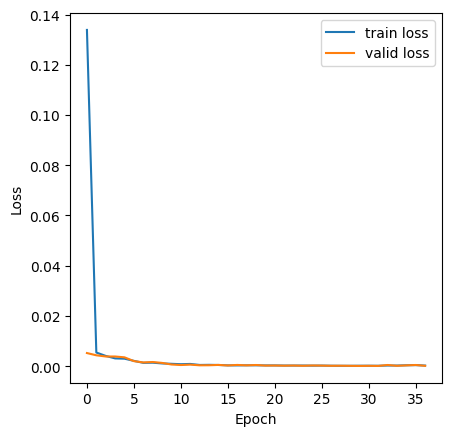

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 22
min train loss: 0.0001264741865518524
min valid loss: 0.00013254229921394174


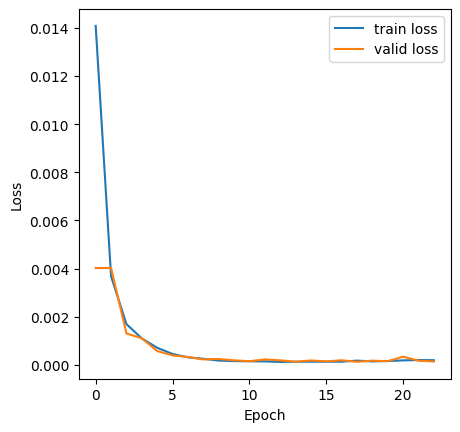

CV round 1_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.00021966201020404697
min valid loss: 0.00020218847384967376


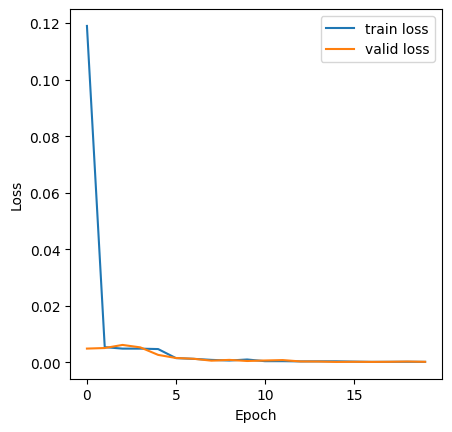

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.00015819882818587675
min valid loss: 0.00013209282386876446


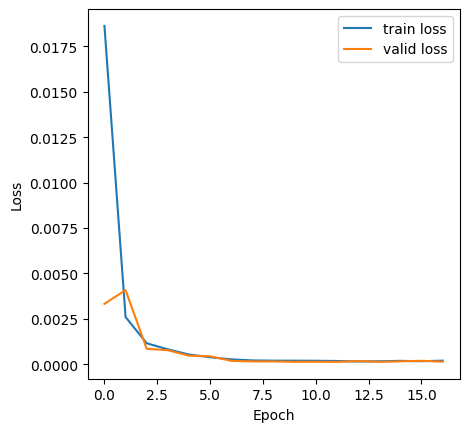

CV round 2_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 30
min train loss: 0.00011669437712539961
min valid loss: 0.00012689219988715195


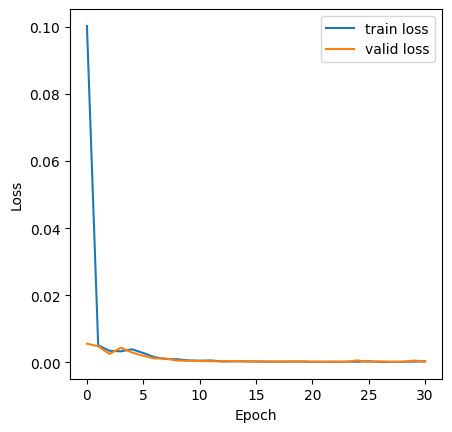

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 26
min train loss: 0.00014567224510149876
min valid loss: 0.00018443213450250608


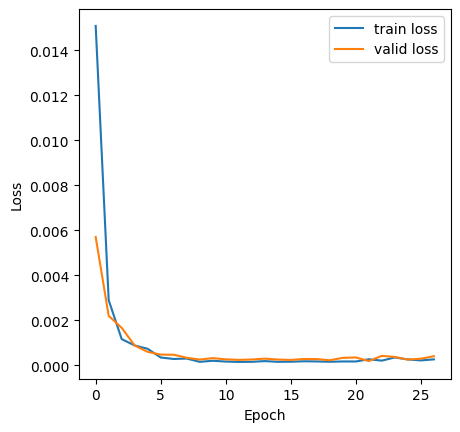

CV round 3_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 28
min train loss: 0.00017266089727689343
min valid loss: 0.0001491742282269115


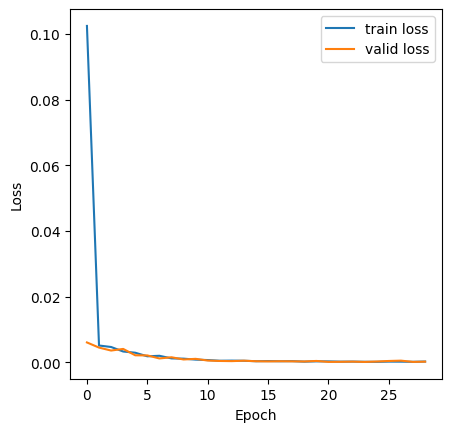

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.0001278346096638195
min valid loss: 0.00019938139073354634


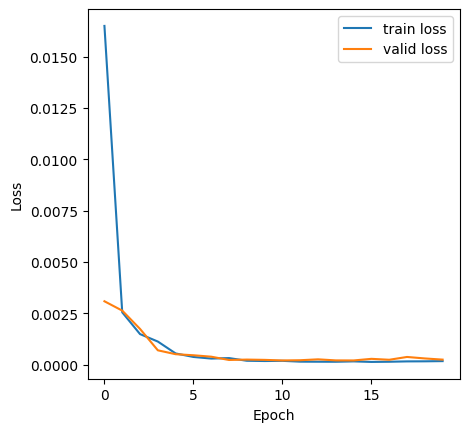

CV round 4_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 22
min train loss: 0.00017219062908473213
min valid loss: 0.00017667932752374327


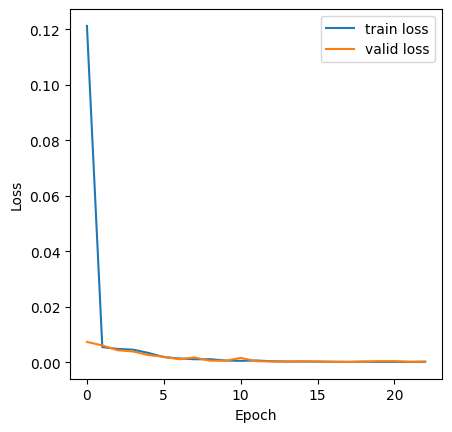

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 15
min train loss: 0.00012797431259748532
min valid loss: 0.00010258461598392674


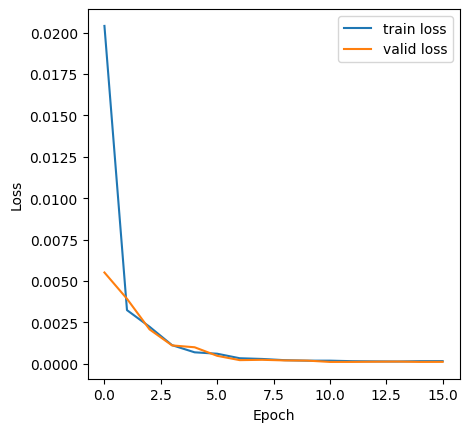

CV round 5_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 24
min train loss: 0.00014000867287739476
min valid loss: 0.0001241378954546235


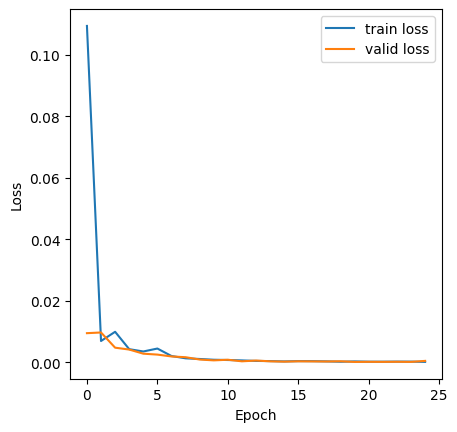

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.00013216713046638301
min valid loss: 0.00011360086577233712


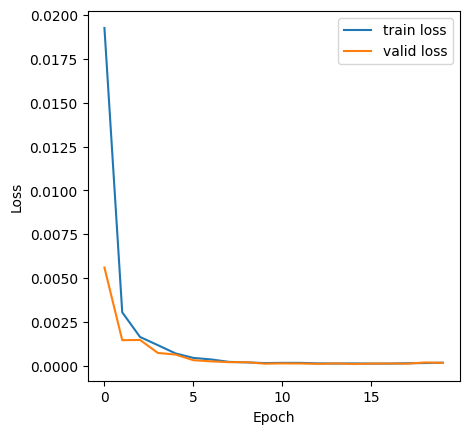

CV round 6_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 25
min train loss: 0.00013834879044390453
min valid loss: 0.00015112852406673483


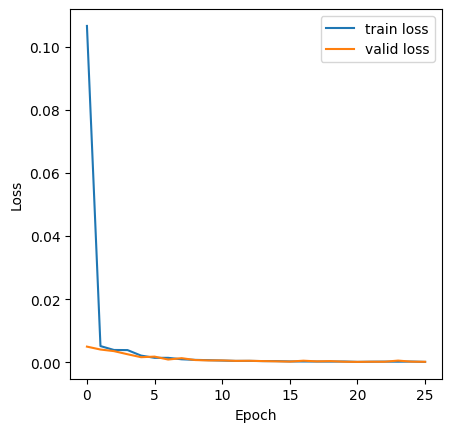

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.0001382344484447844
min valid loss: 0.00013115263707157667


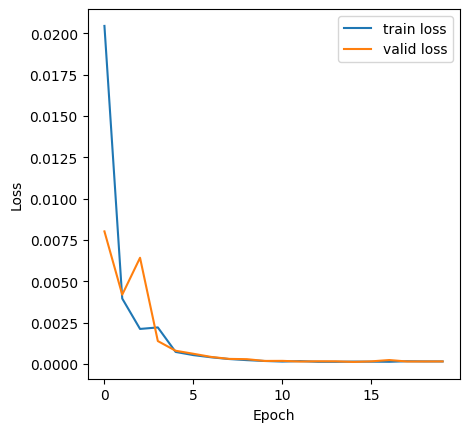

CV round 7_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 20
min train loss: 0.00018662456244452518
min valid loss: 0.0001978928703465499


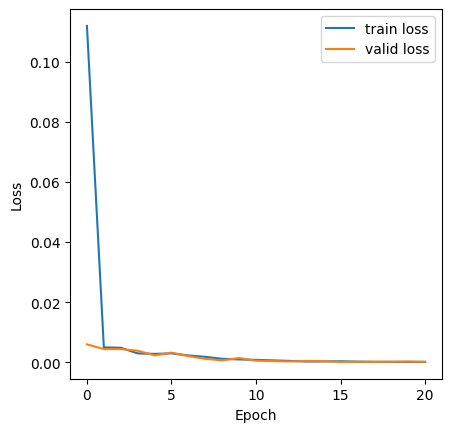

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.00013202203276843207
min valid loss: 0.00016149899831936253


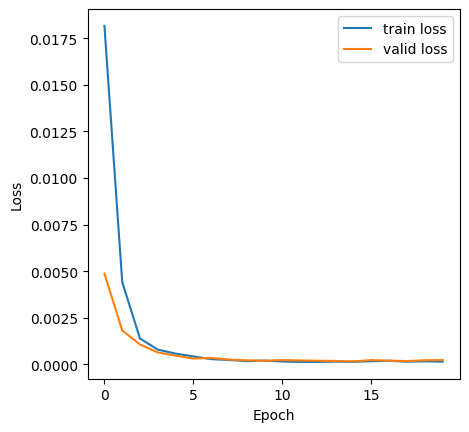

CV round 8_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 34
min train loss: 0.00011762967439029705
min valid loss: 8.925914789870149e-05


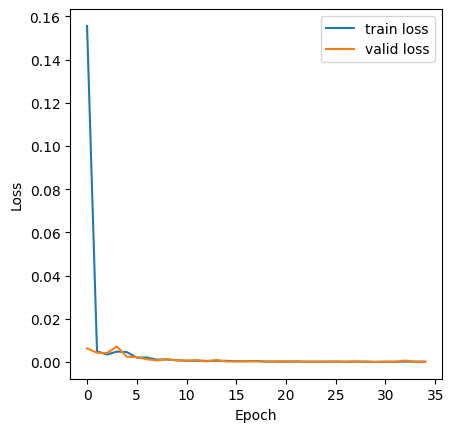

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.00013839499647336638
min valid loss: 0.00014172188419156315


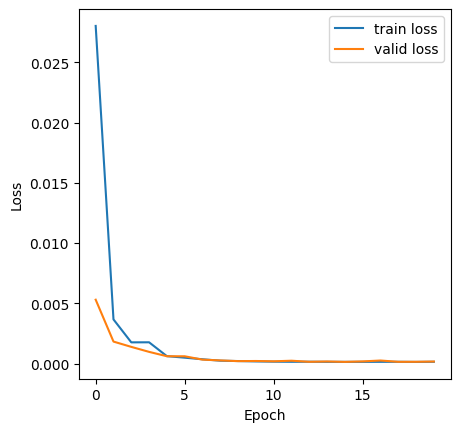

CV round 9_________________________________
using 0 pressure_230516_discrete


KeyboardInterrupt: 

In [20]:
from CrossValidation import CrossValidator
from tools import SaveBestCrossValidationModel
from Siamese import SiameseDataset, SiameseAuxManager
from data import alternate_rows_itertools
datas = [s['data P'], s['data T']]
# datas.reverse()
CVtor = CrossValidator(s['cross validation round'], 
                       s['epoch'], 
                       SaveBestCrossValidationModel(s['best model folder']), 
                       SiameseDataset,
                       datas,
                       data_dictionary,
                       SiameseAuxManager,
                       s,
                       device)
# CVtor.single_task_train(0)
CVtor.multi_task_train_sequential()
# CVtor.multi_task_train_weave(alternate_rows_itertools) 
CVtor.complete_notify()
CVtor.test_all()

CV round 0_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 29
min train loss: 0.00014519409864574714
min valid loss: 0.00010625266077113338


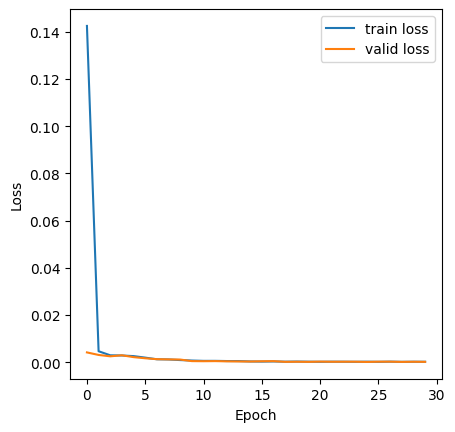

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.00015149164254112156
min valid loss: 0.00014936876514663085


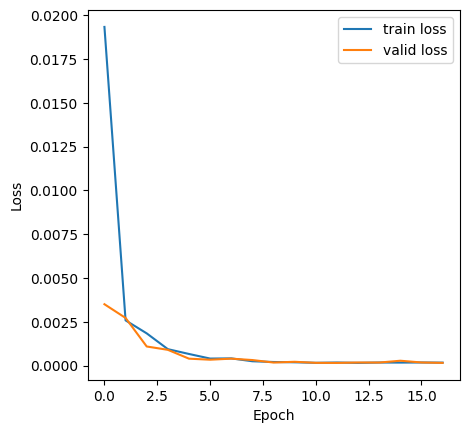

CV round 1_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 32
min train loss: 0.00014317120754144113
min valid loss: 9.824548737924488e-05


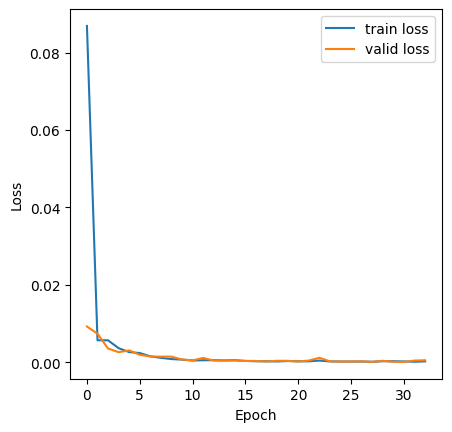

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.00011700014836220141
min valid loss: 9.578145641410772e-05


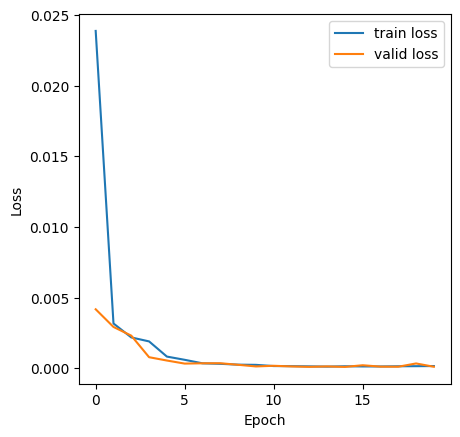

CV round 2_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 27
min train loss: 0.0001283845605609134
min valid loss: 9.552323558636999e-05


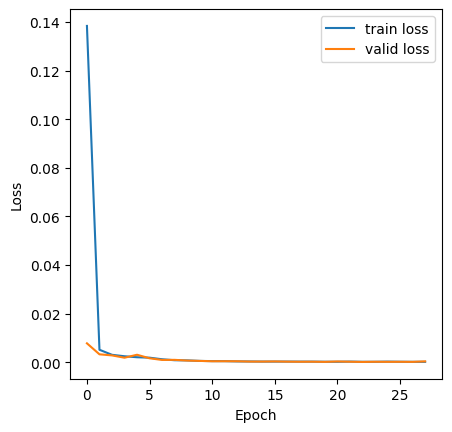

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.00011318873390392224
min valid loss: 0.00017678985348443108


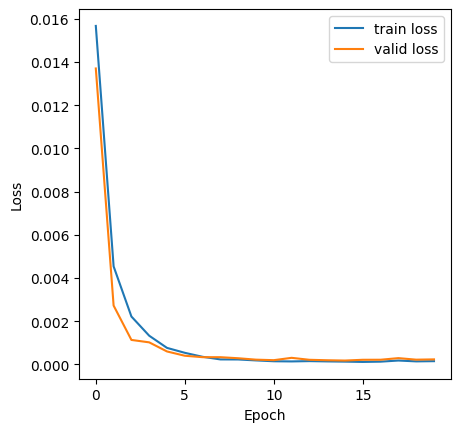

CV round 3_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 34
min train loss: 0.00011447524497767022
min valid loss: 8.503809317517153e-05


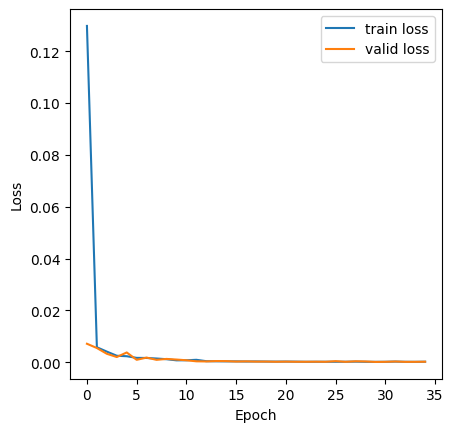

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 17
min train loss: 0.00013506095037331707
min valid loss: 0.0002061063251427473


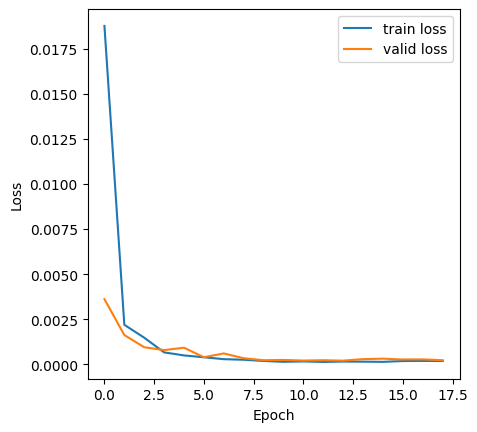

CV round 4_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 30
min train loss: 0.00010955550642393064
min valid loss: 0.00010087081318488345


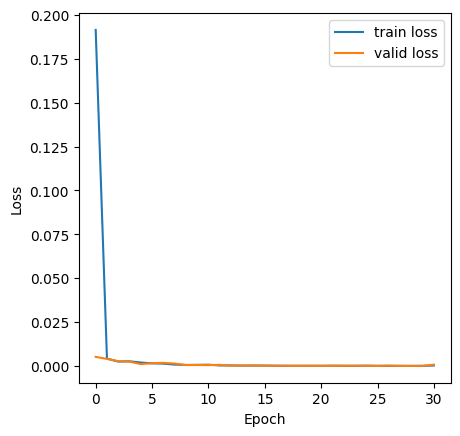

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.00014874469150416905
min valid loss: 9.170595608578112e-05


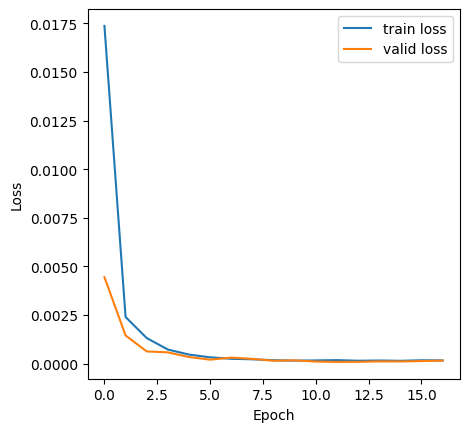

CV round 5_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 24
min train loss: 0.0001915362373851663
min valid loss: 0.0001523115120107832


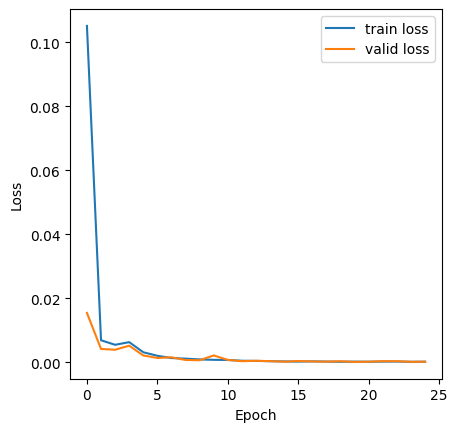

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.00014647807606569117
min valid loss: 0.00011521402139853882


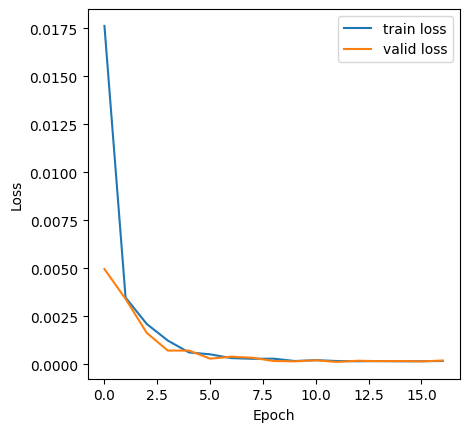

CV round 6_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 32
min train loss: 0.00010049376561999617
min valid loss: 9.26207424072345e-05


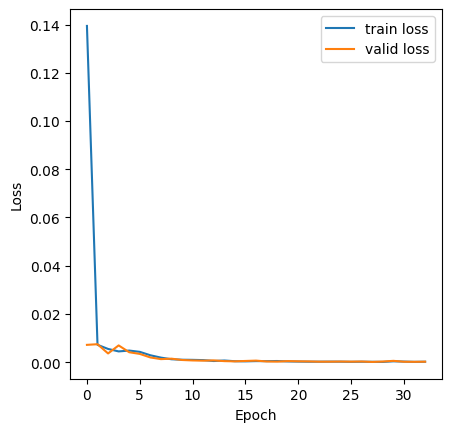

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 22
min train loss: 0.000144632302098299
min valid loss: 0.00012911462985548976


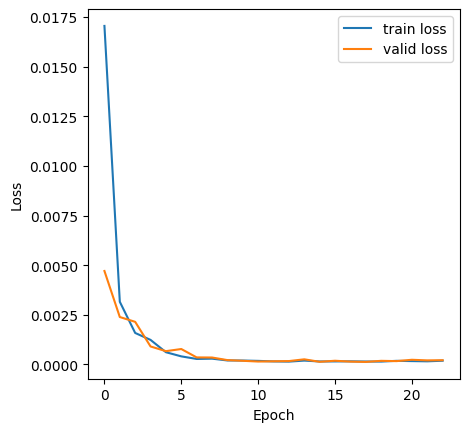

CV round 7_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 39
min train loss: 0.0001397434354823252
min valid loss: 0.00010048803437712195


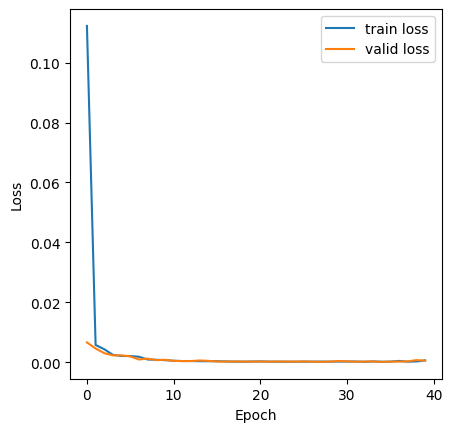

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 20
min train loss: 0.0001283524990702228
min valid loss: 0.00013927100524980282


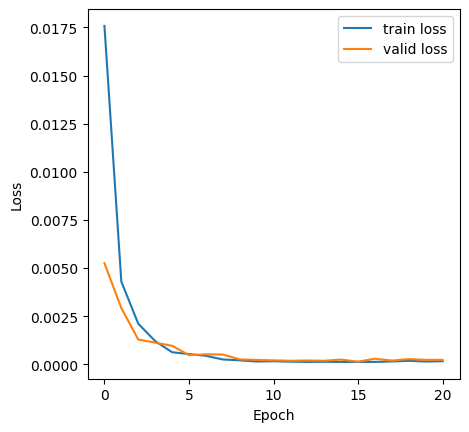

CV round 8_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 30
min train loss: 0.00013684793874827765
min valid loss: 9.003621562442277e-05


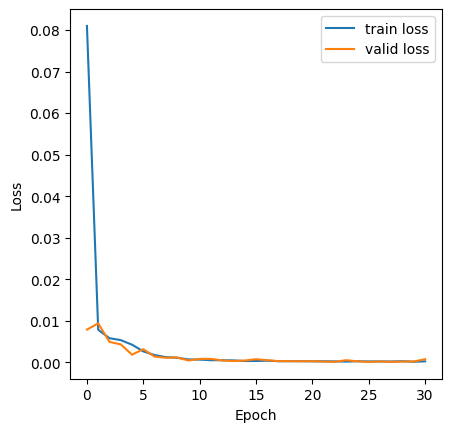

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 18
min train loss: 0.00014350642931910414
min valid loss: 0.00013182269321987405


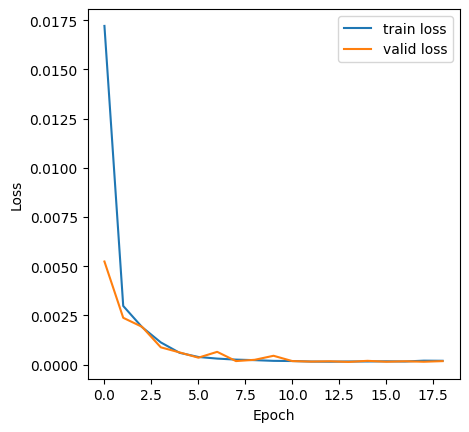

CV round 9_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 26
min train loss: 0.00015068294292591003
min valid loss: 0.00011293592069705483


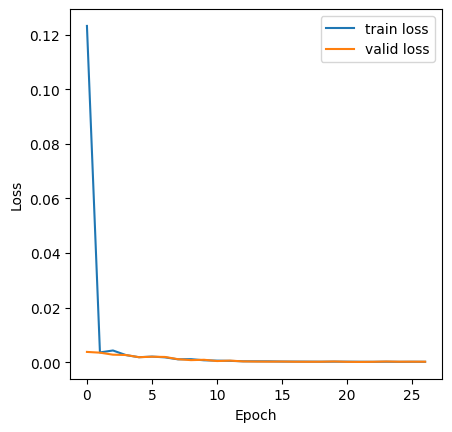

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 18
min train loss: 0.0001233577775317165
min valid loss: 0.00013668386006764578


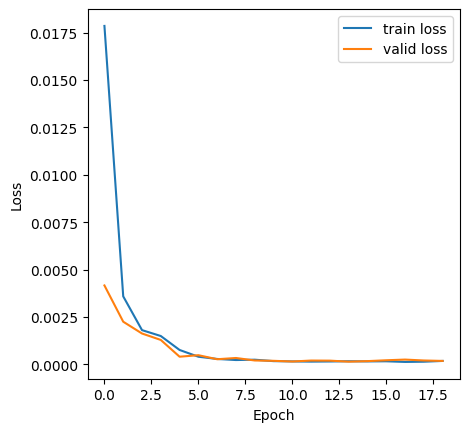

CV round 10_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 15
min train loss: 0.00031765595816647294
min valid loss: 0.0002874869505831157


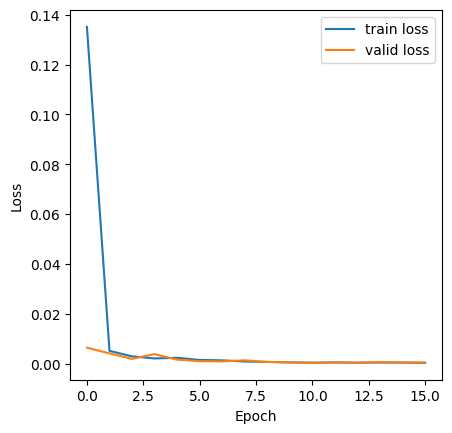

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.0001493880103170699
min valid loss: 0.0001381275718526204


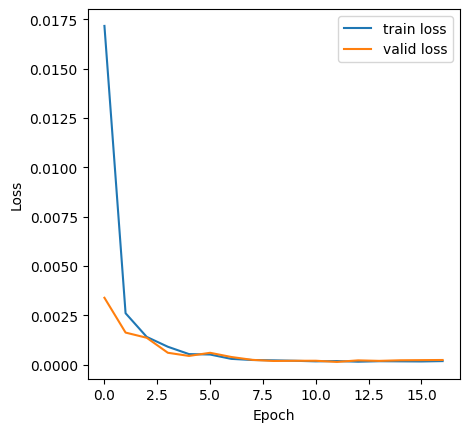

CV round 11_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 22
min train loss: 0.00019635227495613932
min valid loss: 0.00015103440955499536


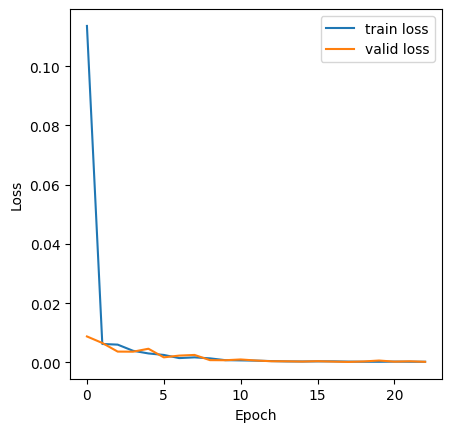

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 24
min train loss: 0.00013461627672354965
min valid loss: 0.00022918695858128272


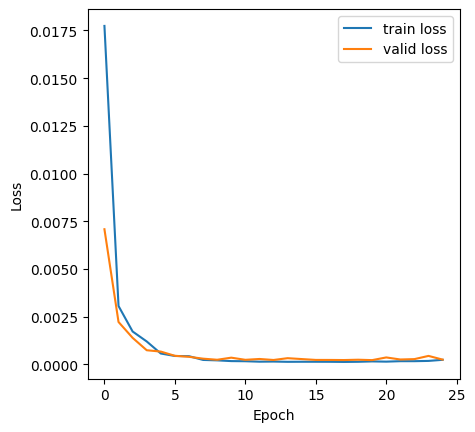

CV round 12_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 34
min train loss: 0.00011979746625663458
min valid loss: 9.747811509441817e-05


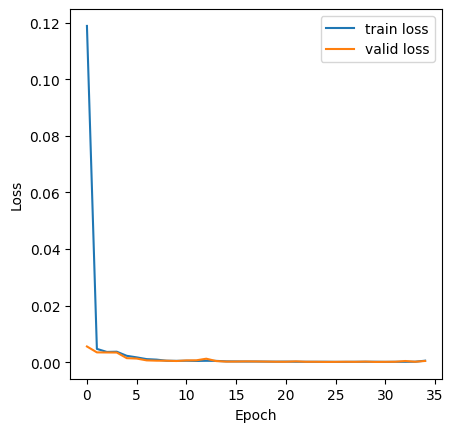

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 18
min train loss: 0.00014882124188178832
min valid loss: 0.0001461044569288405


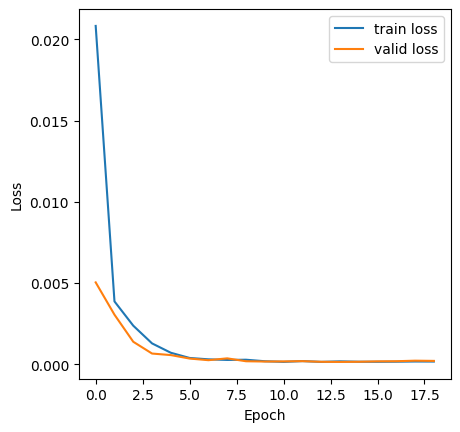

CV round 13_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 26
min train loss: 0.00013143156885979062
min valid loss: 0.00011943892150156898


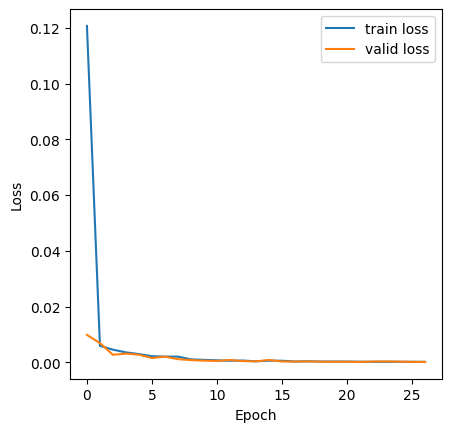

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 17
min train loss: 0.00014963362994449474
min valid loss: 0.0001083409527047096


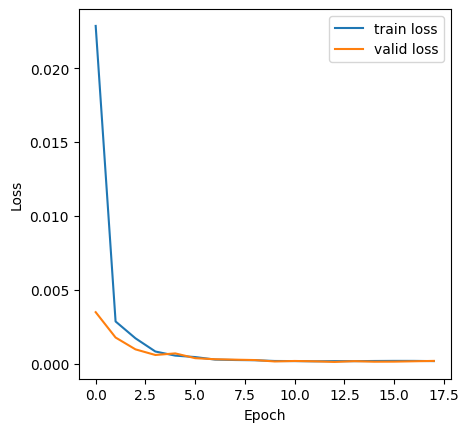

CV round 14_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 22
min train loss: 0.00019671014365898868
min valid loss: 0.00012957676517544314


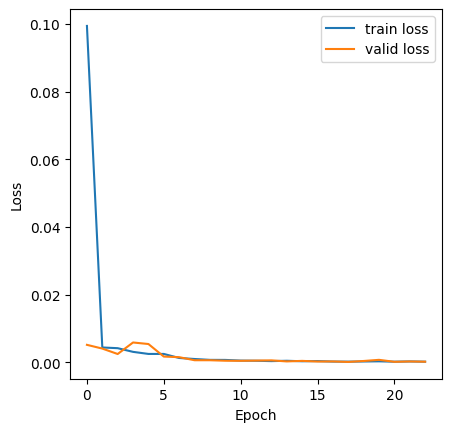

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 20
min train loss: 0.00013052851632396184
min valid loss: 0.00011167671542161291


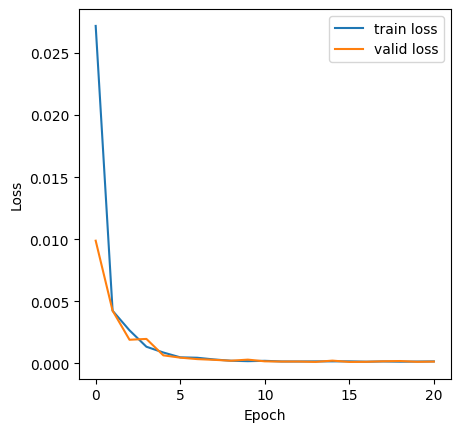

CV round 15_________________________________
using 0 pressure_230516_discrete
EARLY STOPPING @ epoch 21
min train loss: 0.0001524355783079624
min valid loss: 0.00016541179411433404


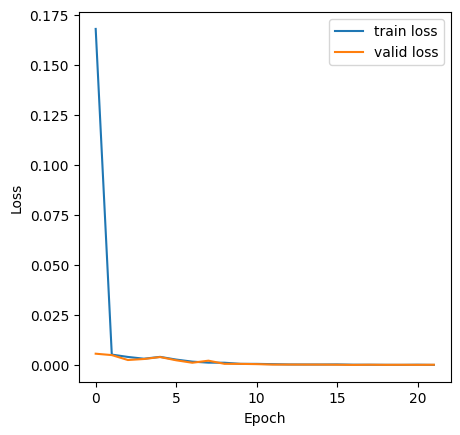

using 1 temperature_230509_discrete
EARLY STOPPING @ epoch 18
min train loss: 0.00011778358186182396
min valid loss: 0.00014439268488786183


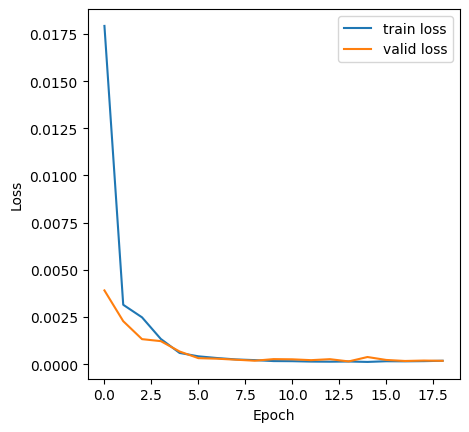



best model is: CV=3.pth with 8.503809317517153e-05


In [17]:
from torch.utils.data import DataLoader
from tools import SiameseDataset, SaveBestCrossValidationModel
from Style import TextColor
from Siamese import SiameseAuxManager

CV_saver = SaveBestCrossValidationModel(s['best model folder'])
epoch = s['epoch']
datas = [s['data P'], s['data T']]

def multi_task_train_sequential():
    cross_validation_loss = []
    for cross_validation_round in range(s['cross validation round']):
        print(f"CV round {cross_validation_round}_________________________________")
        for index, data in enumerate(datas):
            network_object = SiameseAuxManager(epoch, cross_validation_round, s, device)
            print(f"using {index} {data}")
            valid_loss = network_object.train(
                DataLoader(SiameseDataset(
                data_dictionary[data]['data'],
                data_dictionary[data]['label'],
                data_dictionary[data]['train indices'][cross_validation_round],
                device=device,), shuffle=False, batch_size=s['batch size']),
                DataLoader(SiameseDataset(
                data_dictionary[data]['data'],
                data_dictionary[data]['label'],
                data_dictionary[data]['valid indices'][cross_validation_round],
                device=device,), shuffle=False, batch_size=s['batch size']))
            network_object.reset_for_sequential()

            CV_saver(current_loss=valid_loss, round=cross_validation_round)
            cross_validation_loss.append(valid_loss)
multi_task_train_sequential()
print()
print(f"\nbest model is: {CV_saver.best_model_name} with {CV_saver.current_best_loss}")
# print(f"The aggregate performance is: mean {np.mean(cross_validation_loss)}, std {np.std(cross_validation_loss)}")

data: pressure_230516_discrete then pressure_230516_discrete
CV round 0_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 24
min train loss: 0.0001701631351104218
min valid loss: 0.0001713191140879644


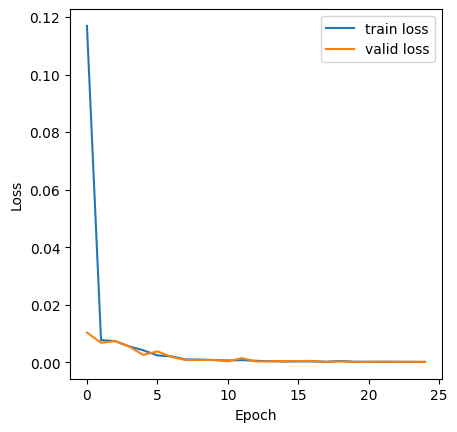

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 26
min train loss: 0.00010799583520620769
min valid loss: 0.00011471976846989587


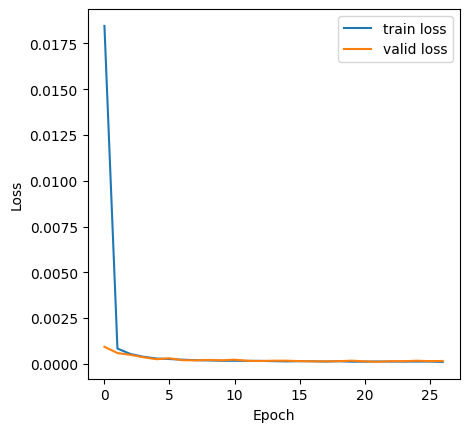

CV round 1_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 33
min train loss: 0.00012330204246443992
min valid loss: 9.246257241102285e-05


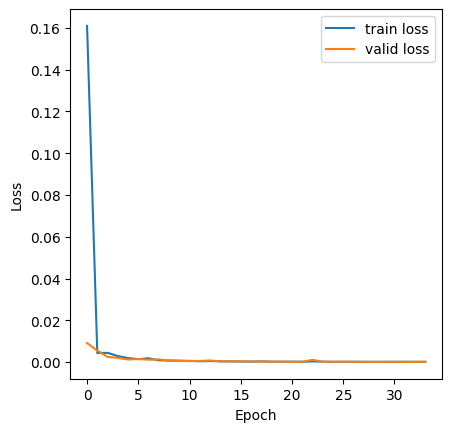

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 21
min train loss: 0.00014775310476331717
min valid loss: 0.00011821312134423734


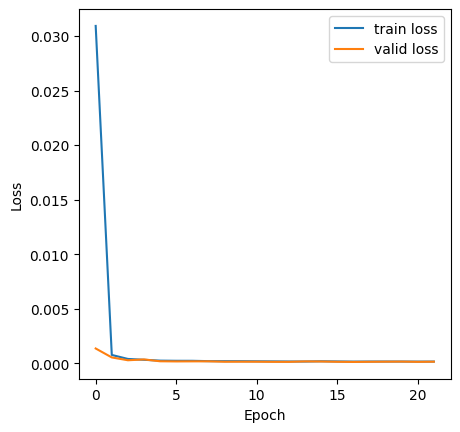

CV round 2_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 29
min train loss: 0.0001453240560129581
min valid loss: 9.783835389498563e-05


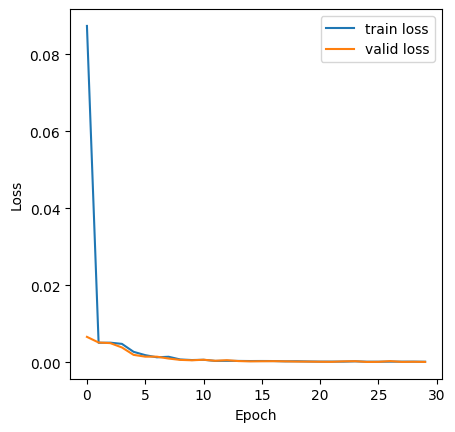

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 13
min train loss: 0.0001510409933182404
min valid loss: 0.0002388786195201407


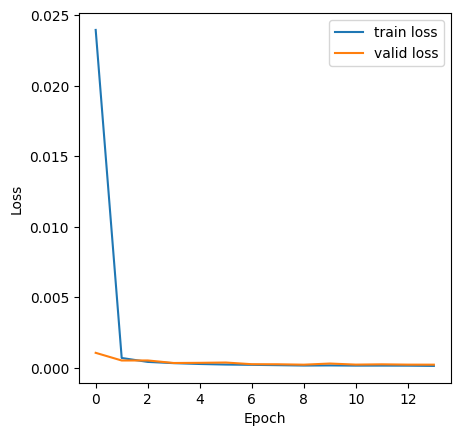

CV round 3_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 29
min train loss: 0.00016481584759524346
min valid loss: 0.0001150069631421502


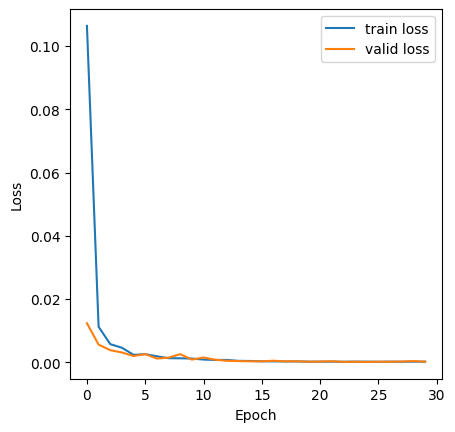

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 18
min train loss: 0.0001404711018205324
min valid loss: 0.00023162583468212304


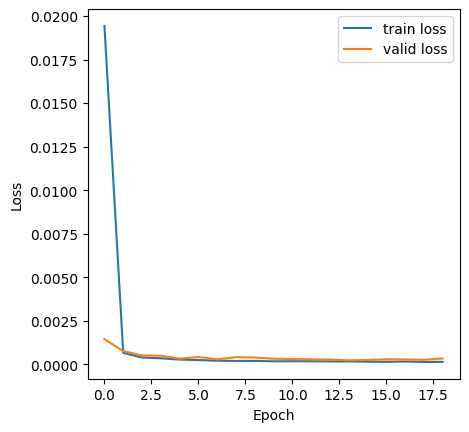

CV round 4_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 22
min train loss: 0.00017544159583683888
min valid loss: 0.00013841939380654367


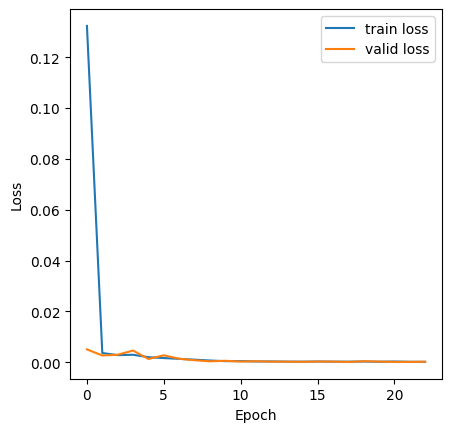

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 29
min train loss: 0.00012520236434669863
min valid loss: 8.765489301846461e-05


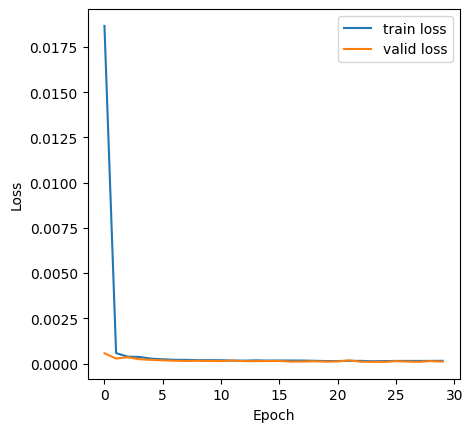

CV round 5_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 23
min train loss: 0.00015746434331628155
min valid loss: 0.0001628221980354283


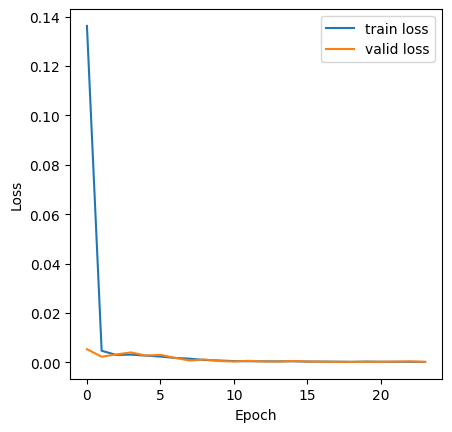

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 17
min train loss: 0.00014234195626186468
min valid loss: 0.0001374468552775828


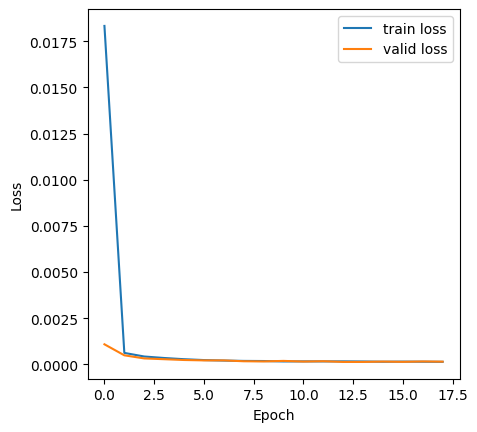

CV round 6_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 30
min train loss: 0.000129049181487062
min valid loss: 0.0001701329192655976


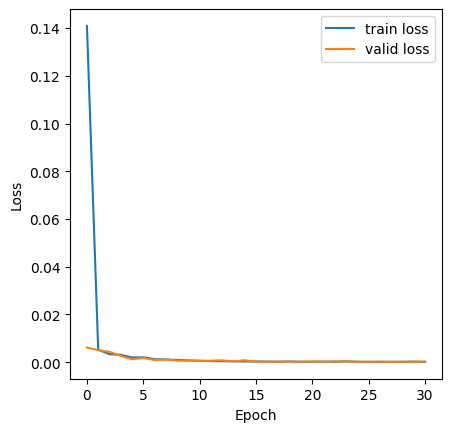

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 20
min train loss: 0.00013413286265087223
min valid loss: 0.00015193980423071864


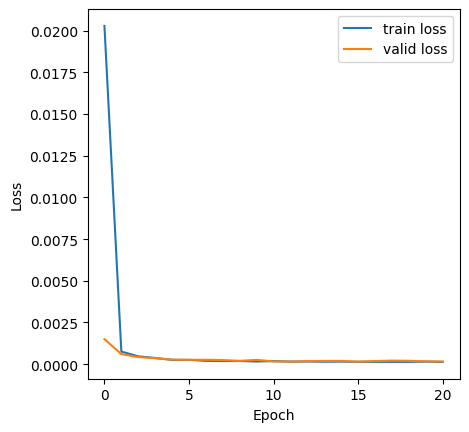

CV round 7_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 25
min train loss: 0.00019586409934246066
min valid loss: 0.00011824898615486745


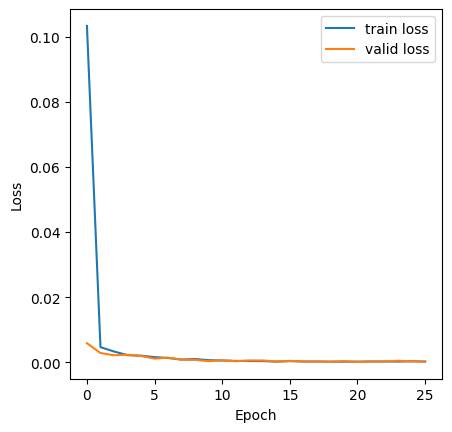

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 15
min train loss: 0.00013204415269931567
min valid loss: 0.0002323765913484079


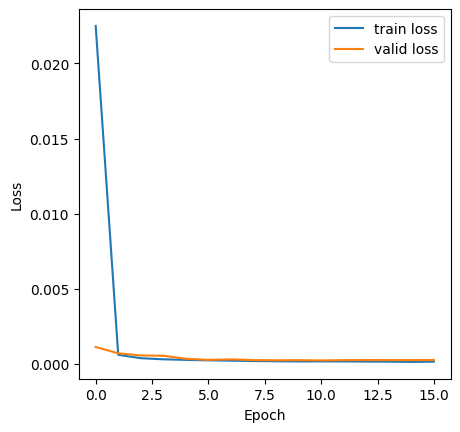

CV round 8_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 30
min train loss: 0.0001407111404246693
min valid loss: 0.00010455942583575961


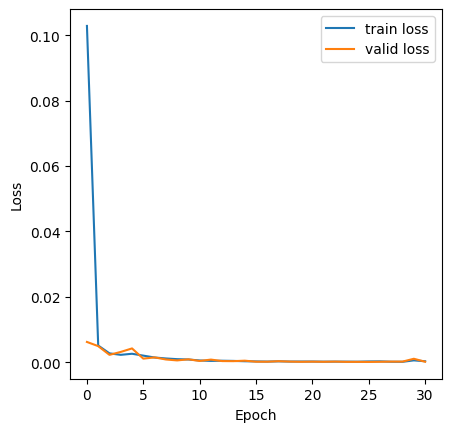

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 15
min train loss: 0.00013039534419614498
min valid loss: 0.00013101559306960553


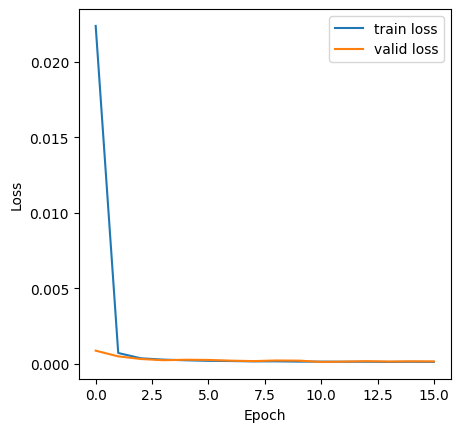

CV round 9_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 19
min train loss: 0.0002724922061051157
min valid loss: 0.00022675469153909944


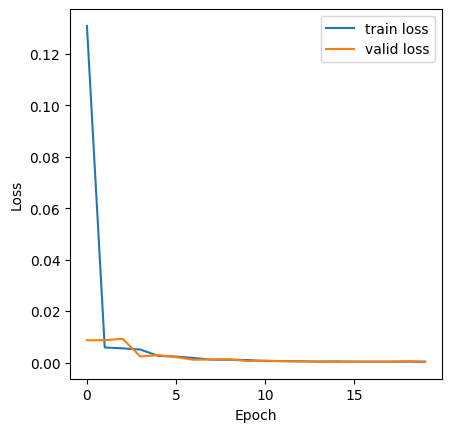

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 28
min train loss: 0.0001263991632020572
min valid loss: 0.00016110323351887544


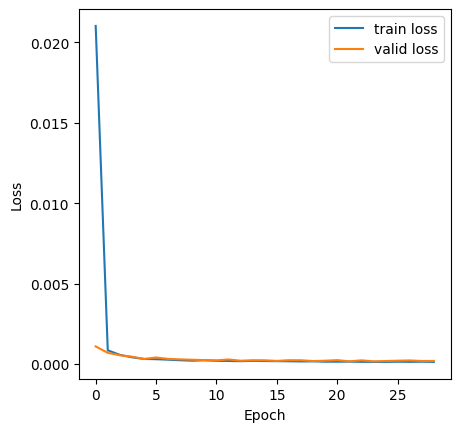

CV round 10_________________________________
using pressure_230516_discrete


KeyboardInterrupt: 

In [9]:
from torch.utils.data import DataLoader
from tools import SiameseDataset, SaveBestCrossValidationModel

CV_saver = SaveBestCrossValidationModel(s['best model folder'])
test_indices = data_dictionary[s['data P']]['test indices']
epoch = s['epoch']
print(f"data: {s['data P']} then {s['data P']}")
cross_validation_loss = []
for cross_validation_round in range(s['cross validation round']):
    if cross_validation_round < s['cross validation round']:
        print(f"CV round {cross_validation_round}_________________________________")
        network_object = Manager(epoch, cross_validation_round)
        print(f"using {s['data P']}")
        valid_loss = network_object.train(
            DataLoader(SiameseDataset(
            data_dictionary[s['data P']]['data'],
            data_dictionary[s['data P']]['label'],
            data_dictionary[s['data P']]['train indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']),
            DataLoader(SiameseDataset(
            data_dictionary[s['data P']]['data'],
            data_dictionary[s['data P']]['label'],
            data_dictionary[s['data P']]['valid indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']))
        print(f"using {s['data T']}")
        network_object._saver.reset()
        network_object._stopper.reset()
        network_object._train_loss = []
        network_object._valid_loss = []
        # reset auxiliary network
        network_object._network.auxiliary_sequential.apply(network_object.initializer)
        print(f"reset: train & valid loss, early stopper, saver, auxiliary section")
        valid_loss = network_object.train(
            DataLoader(SiameseDataset(
            data_dictionary[s['data T']]['data'],
            data_dictionary[s['data T']]['label'],
            data_dictionary[s['data T']]['train indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']),
            DataLoader(SiameseDataset(
            data_dictionary[s['data T']]['data'],
            data_dictionary[s['data T']]['label'],
            data_dictionary[s['data T']]['valid indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']))
        CV_saver(current_loss=valid_loss, round=cross_validation_round)
        cross_validation_loss.append(valid_loss)
print()
print(f"\nbest model is: {CV_saver.best_model_name} with {CV_saver.current_best_loss}")
print(f"The aggregate performance is: mean {np.mean(cross_validation_loss)}, std {np.std(cross_validation_loss)}")

data: pressure_230516_discrete then pressure_230516_discrete
CV round 0_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 29
min train loss: 0.00014534102639035236
min valid loss: 0.00011695729926941567


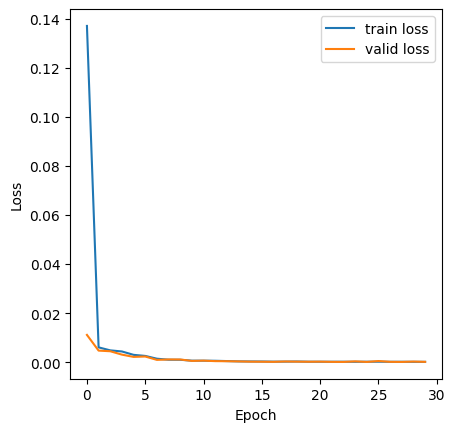

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 22
min train loss: 0.0001299323586835905
min valid loss: 0.00013316382271449058


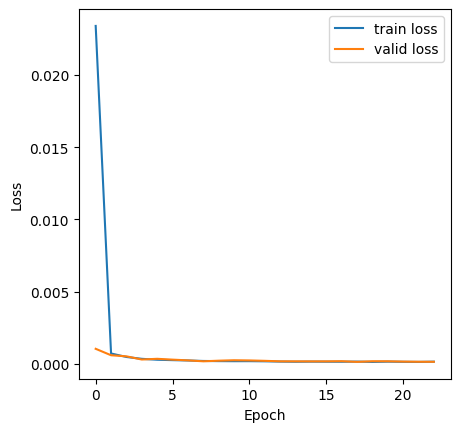

CV round 1_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 32
min train loss: 0.00016150548624202862
min valid loss: 0.00010502163331693737


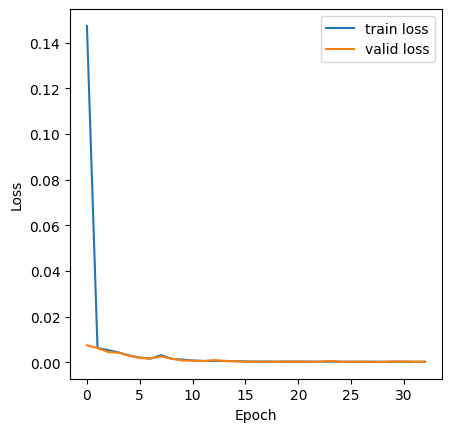

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 19
min train loss: 0.0001405451707658799
min valid loss: 0.0001173745967159783


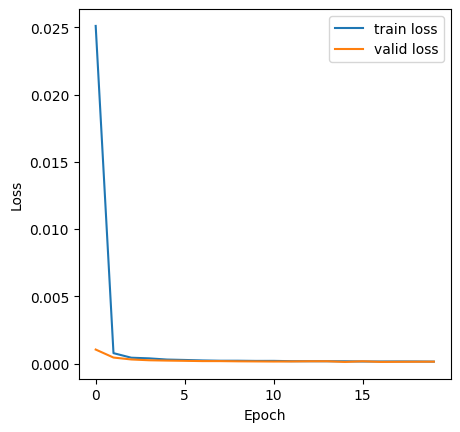

CV round 2_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 24
min train loss: 0.00015452651820272546
min valid loss: 0.00014496836683974834


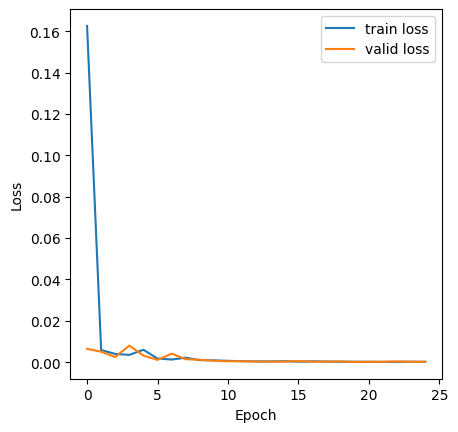

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 15
min train loss: 0.00016494950473729247
min valid loss: 0.00021955417928678033


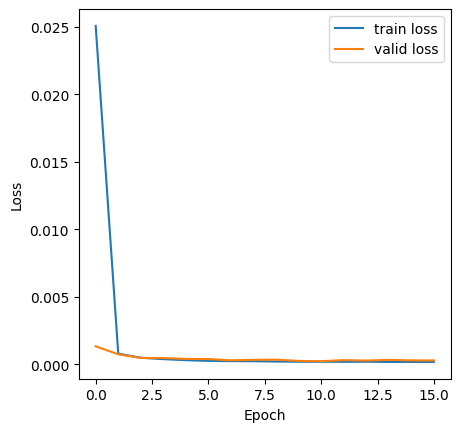

CV round 3_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 20
min train loss: 0.00022402942671429958
min valid loss: 0.0002026330057560699


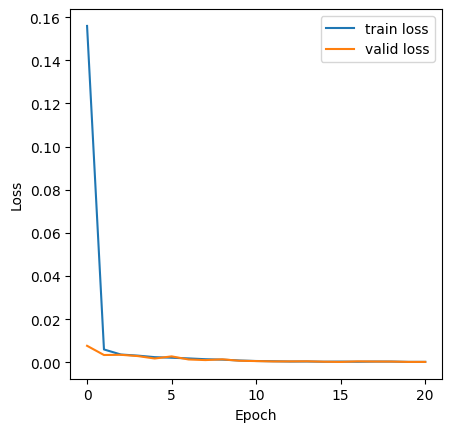

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 24
min train loss: 0.00012288379297608503
min valid loss: 0.0002187398456858079


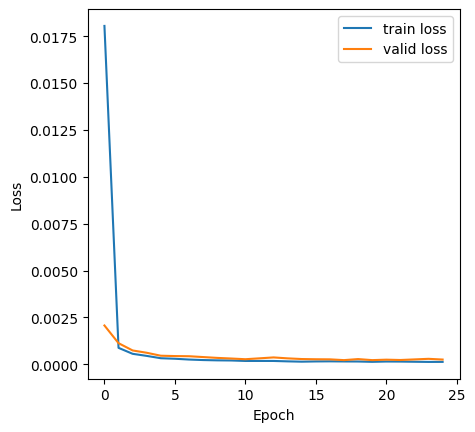

CV round 4_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 27
min train loss: 0.00014154421392463106
min valid loss: 0.00012120838255214039


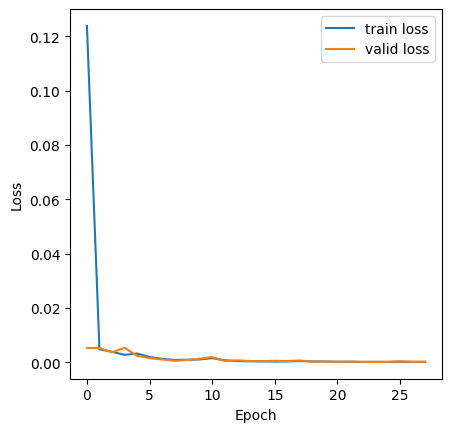

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 26
min train loss: 0.00011983714235115754
min valid loss: 0.00010012129994146035


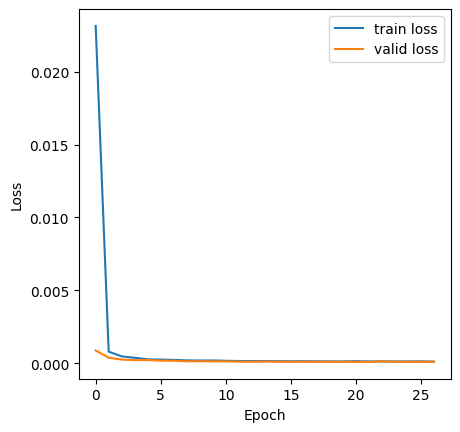

CV round 5_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 25
min train loss: 0.00012708871145150624
min valid loss: 0.00010956177766274777


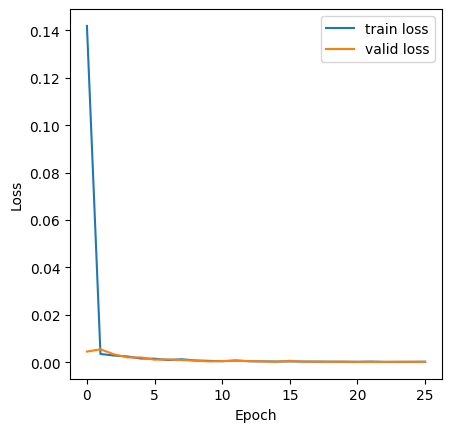

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 19
min train loss: 0.0001419262060869986
min valid loss: 0.0001540826218077104


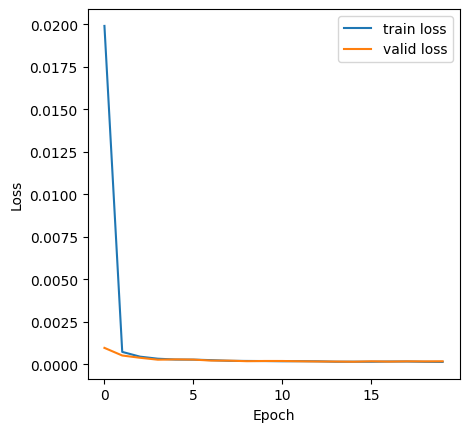

CV round 6_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 25
min train loss: 0.00015778720259153158
min valid loss: 0.0001244322997990821


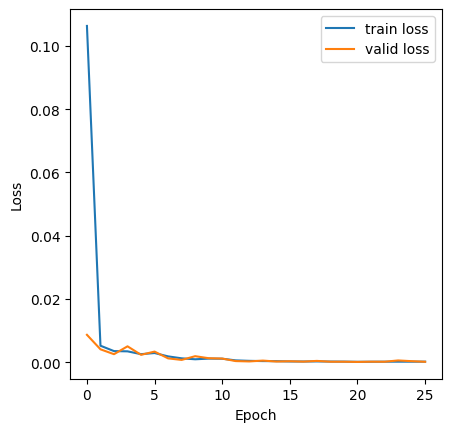

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 32
min train loss: 0.00010599592093113284
min valid loss: 0.00012554704230033646


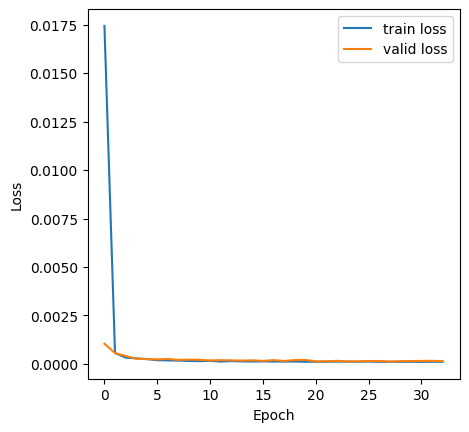

CV round 7_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 33
min train loss: 0.00012606287802389654
min valid loss: 0.0001263603342067654


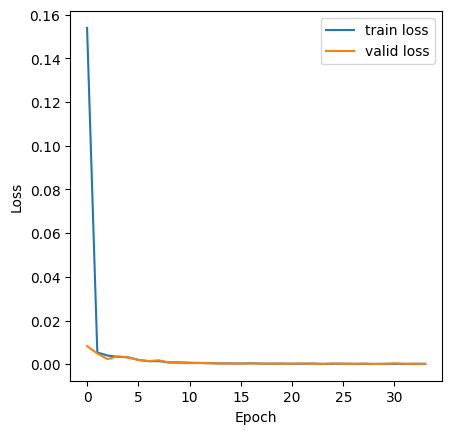

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 18
min train loss: 0.00013445910269982767
min valid loss: 0.000202666506083915


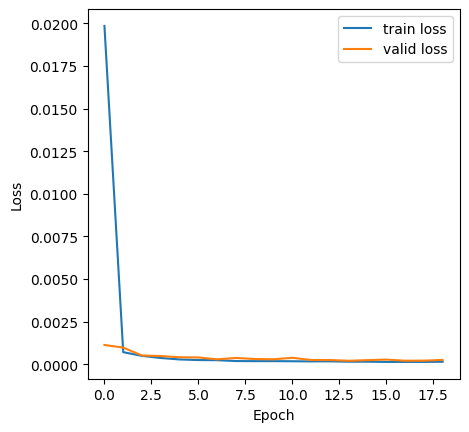

CV round 8_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 23
min train loss: 0.00018105368822447915
min valid loss: 0.00013256374268166837


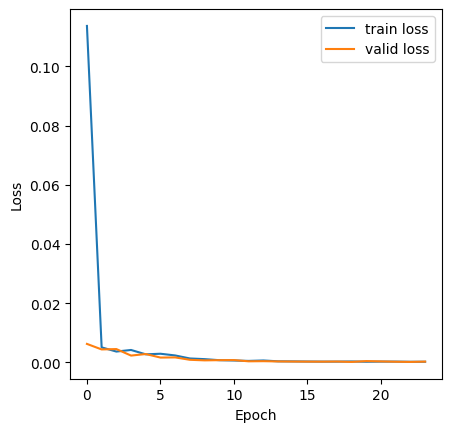

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 23
min train loss: 0.0001322252230624365
min valid loss: 0.00012096100506728123


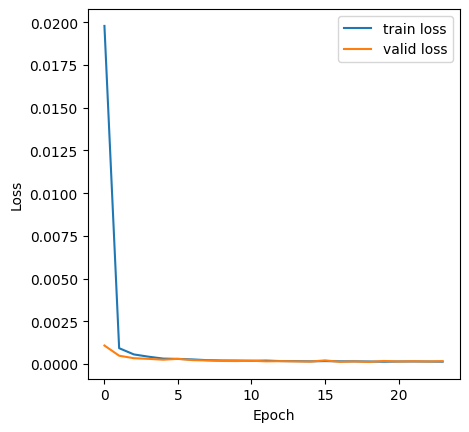

CV round 9_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 39
min train loss: 0.0001385522689485118
min valid loss: 9.64189825936046e-05


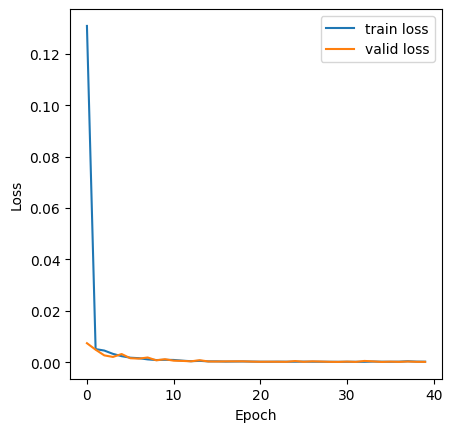

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 12
min train loss: 0.0001511012617839063
min valid loss: 0.00017589735714289802


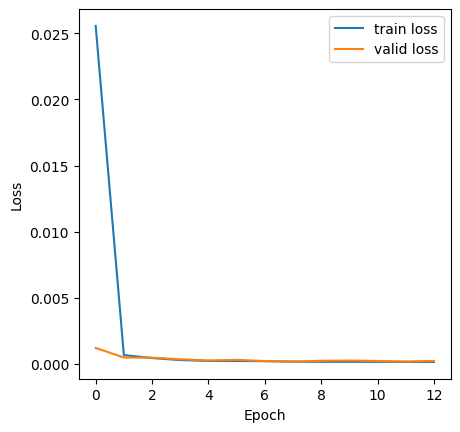

CV round 10_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 22
min train loss: 0.00019191659488238986
min valid loss: 0.0002004950165428454


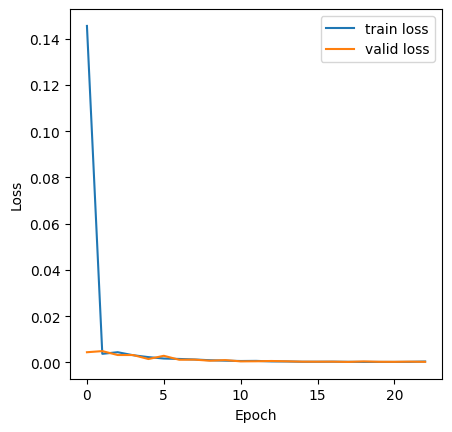

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 19
min train loss: 0.00014426415302957386
min valid loss: 0.00017785898748307342


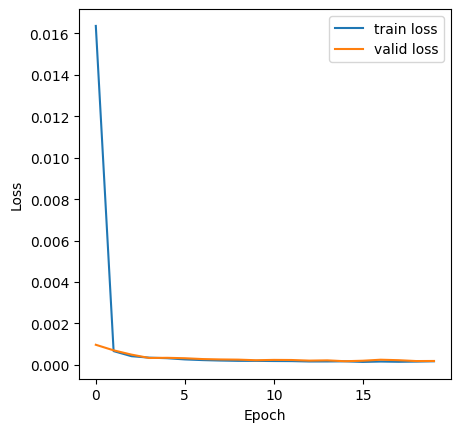

CV round 11_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 27
min train loss: 0.00014010806050712498
min valid loss: 0.00014460851434705546


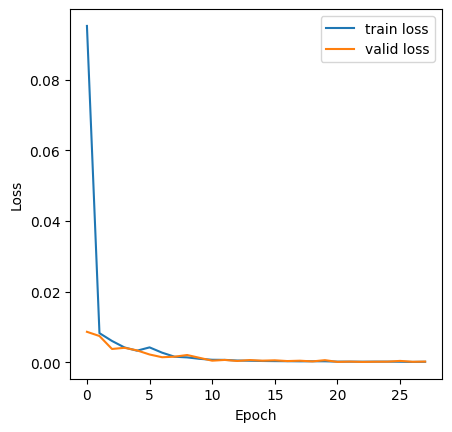

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 27
min train loss: 0.00011625727791287125
min valid loss: 0.00022516738911355403


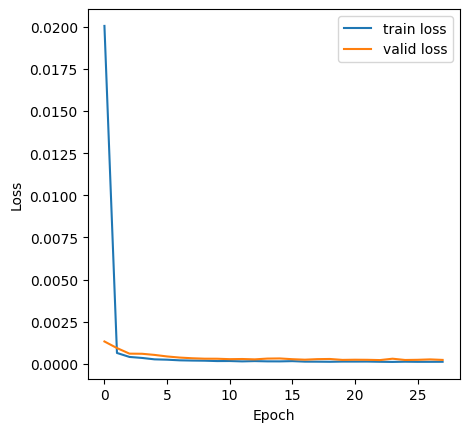

CV round 12_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 27
min train loss: 0.00013116487706693906
min valid loss: 0.00011731743688869756


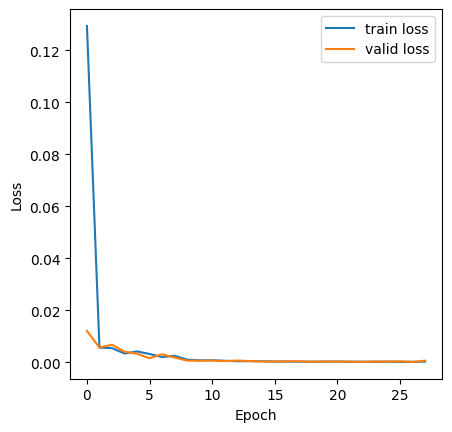

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 26
min train loss: 0.0001264130094182981
min valid loss: 0.00016183747337843095


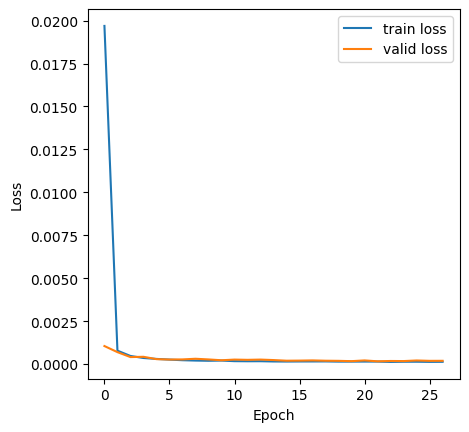

CV round 13_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 21
min train loss: 0.00016982916726688432
min valid loss: 0.00021788452977489214


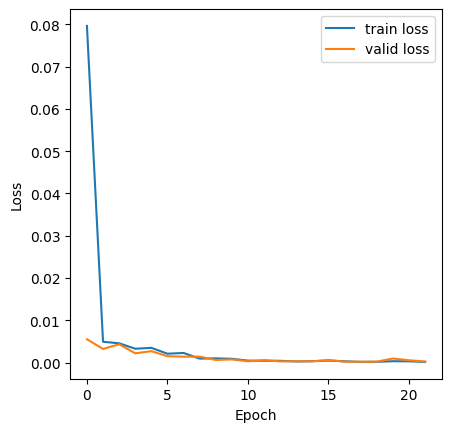

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 27
min train loss: 0.00012374229625107324
min valid loss: 0.00011688356837686642


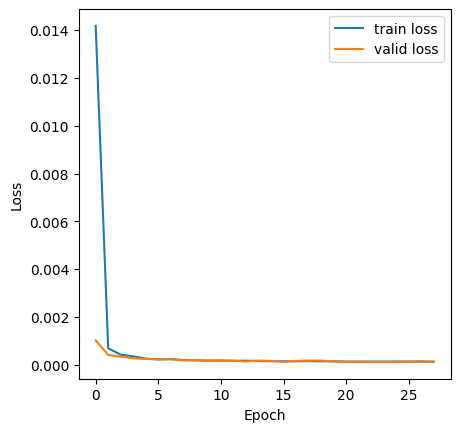

CV round 14_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 30
min train loss: 0.0001226585736400342
min valid loss: 0.00010579890317785612


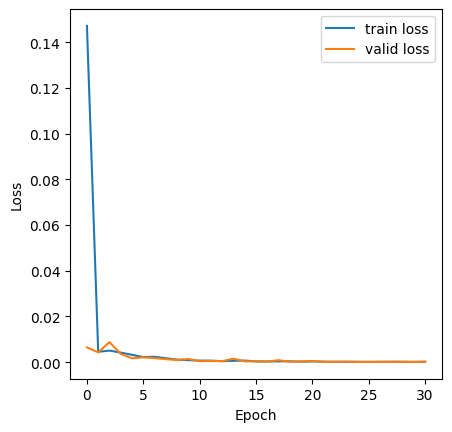

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 29
min train loss: 0.00012398441969818316
min valid loss: 0.0001227320171892643


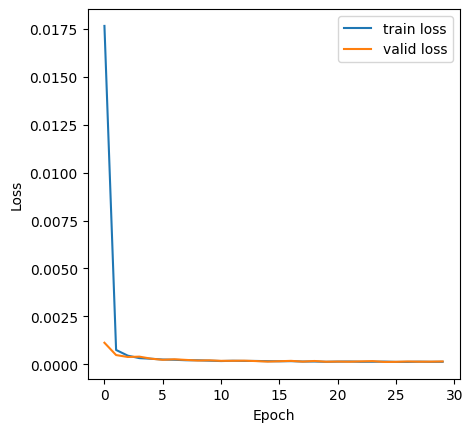

CV round 15_________________________________
using pressure_230516_discrete
EARLY STOPPING @ epoch 31
min train loss: 0.00011490992226092864
min valid loss: 0.0001144930865848437


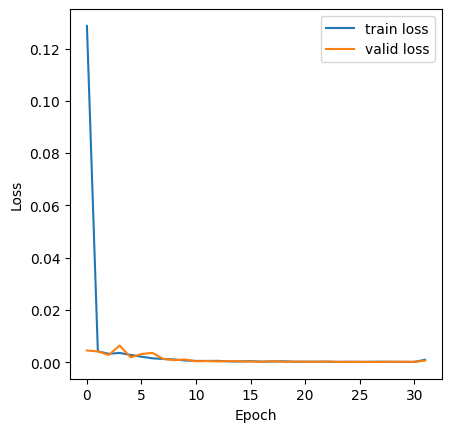

using temperature_230509_discrete
reset: train & valid loss, early stopper, saver, auxiliary section
EARLY STOPPING @ epoch 17
min train loss: 0.00012581303352624562
min valid loss: 0.0001388697269966973


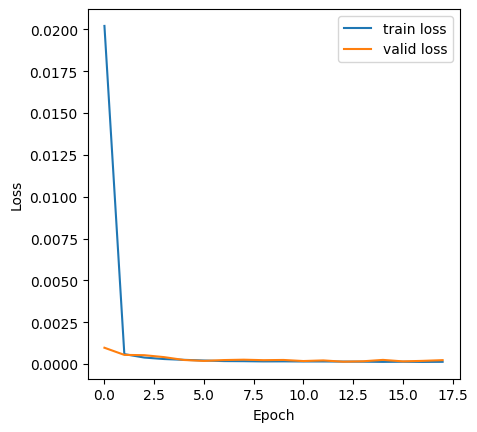



best model is: CV=4.pth with 0.00010012129994146035
The aggregate performance is: mean 0.00015696608995528408, std 4.035398648848939e-05


In [7]:
"""Target result"""

In [8]:
network_object._network.load_state_dict(torch.load(s['best model folder'] + CV_saver.best_model_name))
test_loss = network_object.test(
            DataLoader(SiameseDataset(
            data_dictionary[s['data P']]['data'],
            data_dictionary[s['data P']]['label'],
            data_dictionary[s['data P']]['test indices'],
            device=device,), shuffle=False, batch_size=s['batch size']))
print(f"testing loss: for {s['data P']}: {test_loss}")
test_loss = network_object.test(
            DataLoader(SiameseDataset(
            data_dictionary[s['data T']]['data'],
            data_dictionary[s['data T']]['label'],
            data_dictionary[s['data T']]['test indices'],
            device=device,), shuffle=False, batch_size=s['batch size']))
print(f"testing loss: for {s['data T']}: {test_loss}")

testing loss: for pressure_230516_discrete: 3.895431809127331
testing loss: for temperature_230509_discrete: 0.00011806707755711518
